In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import umap

In [2]:
with open('synset.txt') as f:
    synset = f.readlines()
synset = [x.strip() for x in synset] 
synset = [x.split(' ') for x in synset]

In [3]:
synset[0]

['n02119789', '1', 'kit_fox']

In [4]:
with open('imagenet_2012_challenge_label_map_proto_edited.json') as f:
    synset_target_mapping = json.load(f)

In [5]:
# synset_target_mapping

In [6]:
target_synset_mapping = dict((v,k) for k,v in synset_target_mapping.items())

In [7]:
# target_synset_mapping

In [8]:
imagenet_dict_by_synset = {}
for c in synset:
    imagenet_dict_by_synset[c[0]] = {
        'synset': c[0],
        'label': c[1],
        'name': c[2].lower(),
        'topChannels': {},
        'embedding': {},
        'accuracies': [],
        'topOneAccCount': 0
    }
for i, c in enumerate(synset_target_mapping):
    imagenet_dict_by_synset[c]['target_class'] = i

In [9]:
# imagenet_dict_by_synset

In [10]:
imagenet_dict_by_id = {}
for c in imagenet_dict_by_synset:
    imagenet_dict_by_id[imagenet_dict_by_synset[c]['label']] = imagenet_dict_by_synset[c]

In [11]:
imagenet_dict_by_id['1']

{'synset': 'n02119789',
 'label': '1',
 'name': 'kit_fox',
 'topChannels': {},
 'embedding': {},
 'accuracies': [],
 'topOneAccCount': 0,
 'target_class': 278}

In [12]:
# num_of_classes = 1000
layers = [
    'mixed3a',
    'mixed3b',
    'mixed4a',
    'mixed4b',
    'mixed4c',
    'mixed4d',
    'mixed4e',
    'mixed5a',
    'mixed5b'
]

In [13]:
for layer in layers:
    print(layer)
    
    for c in imagenet_dict_by_id:
        imagenet_dict_by_id[c]['topChannels'][layer] = []
    
    M = np.loadtxt('layer-matrices/' + 'M-' + layer + '.csv', delimiter=',', dtype=int)
    
    for c in range(M.shape[0]):
        for ch in range(M.shape[1]):
#             if M[c][ch] != 0:
            if M[int(imagenet_dict_by_id[str(c+1)]['target_class'])][ch] != 0:
                imagenet_dict_by_id[str(c+1)]['topChannels'][layer].append(
                    {
                      'channel': int(ch),
                      'count': int(M[int(imagenet_dict_by_id[str(c+1)]['target_class'])][ch])
                    }
                )

mixed3a
mixed3b
mixed4a
mixed4b
mixed4c
mixed4d
mixed4e
mixed5a
mixed5b


In [14]:
for layer in layers:
    print(layer)
    
    for c in imagenet_dict_by_id:
        unsorted_channels = imagenet_dict_by_id[c]['topChannels'][layer]
        sorted_channels = sorted(unsorted_channels, key=lambda k: k['count'], reverse=True)
        imagenet_dict_by_id[c]['topChannels'][layer] = sorted_channels

mixed3a
mixed3b
mixed4a
mixed4b
mixed4c
mixed4d
mixed4e
mixed5a
mixed5b


mixed3a
(1000, 2)


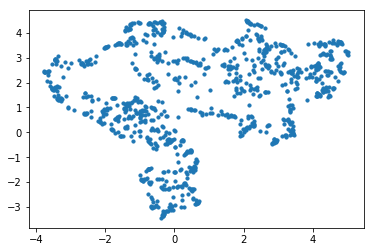

mixed3b
(1000, 2)


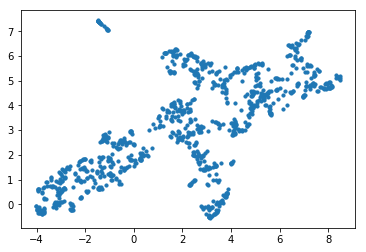

mixed4a
(1000, 2)


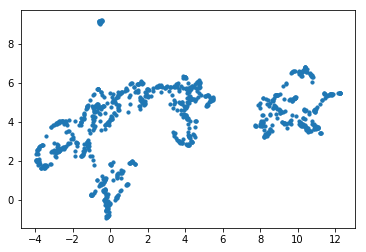

mixed4b
(1000, 2)


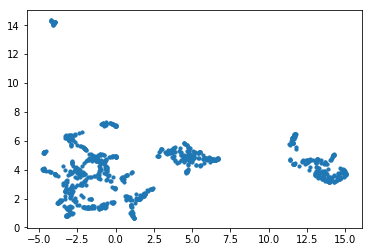

mixed4c
(1000, 2)


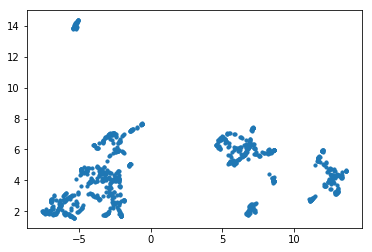

mixed4d
(1000, 2)


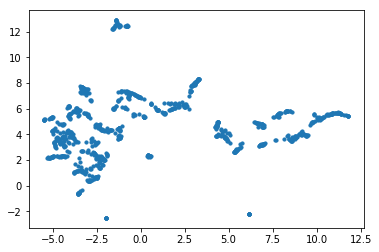

mixed4e
(1000, 2)


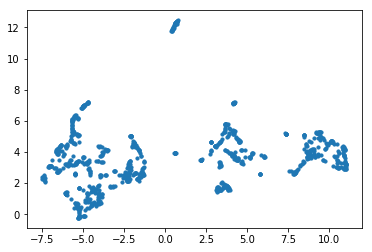

mixed5a
(1000, 2)


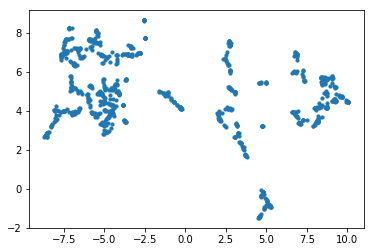

mixed5b
(1000, 2)


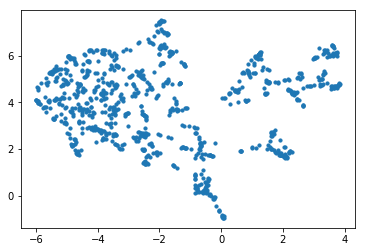

In [15]:
embeddings = []

for i, layer in enumerate(layers):
    print(layer)
    
    M = np.loadtxt('layer-matrices/' + 'M-' + layer + '.csv', delimiter=',', dtype=int)
    
    if layer == 'mixed3a':
        embedding = umap.UMAP(
#             init='random',
            n_components=2,
            metric='cosine',
            n_neighbors=10,
            min_dist=0.001,
            random_state=6510,
            transform_seed=6510
        ).fit_transform(M)
    else:
        embedding = umap.UMAP(
            init=embeddings[i-1],
            n_components=2,
            metric='cosine',
            n_neighbors=10,
            min_dist=0.001,
            random_state=6510,
            transform_seed=6510
        ).fit_transform(M)
    
    print(embedding.shape)
    embeddings.append(embedding)
    
    plt.figure()
    plt.scatter(x=embedding[:,0], y=embedding[:,1], s=10)
    plt.show()
    
    for c in range(M.shape[0]):
        point = embedding[int(imagenet_dict_by_id[str(c+1)]['target_class'])]
        imagenet_dict_by_id[str(c+1)]['embedding'][layer] = {'x':float(point[0]), 'y':float(point[1])}

In [16]:
# add accuracies
with open('layer-matrices/accuracies.json') as f:
    accuracies = json.load(f)

In [17]:
# accuracies

In [18]:
for c in accuracies:
    for img in accuracies[c]:
        imagenet_dict_by_id[imagenet_dict_by_synset[c]['label']]['accuracies'].append(img['argmaxVal'])
        if int(imagenet_dict_by_synset[c]['label']) == int(img['argmax']):
            imagenet_dict_by_id[imagenet_dict_by_synset[c]['label']]['topOneAccCount'] += 1

In [19]:
# add instance count
for c in imagenet_dict_by_id:
    imagenet_dict_by_id[c]['numOfInstances'] = len(imagenet_dict_by_id[c]['accuracies'])

In [20]:
# add accuracy
for c in imagenet_dict_by_id:
    imagenet_dict_by_id[c]['topOneAcc'] = 1.0*imagenet_dict_by_id[c]['topOneAccCount']/imagenet_dict_by_id[c]['numOfInstances']

In [21]:
imagenet_to_save = []
for c in imagenet_dict_by_id:
    imagenet_to_save.append(imagenet_dict_by_id[c])

In [22]:
with open('class-profiles/data/imagenet.json', 'w') as outfile:
    json.dump(imagenet_to_save, outfile)